In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import os

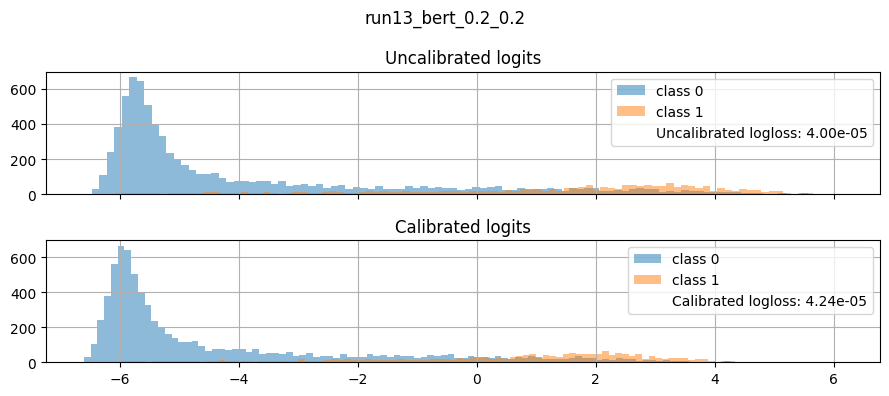

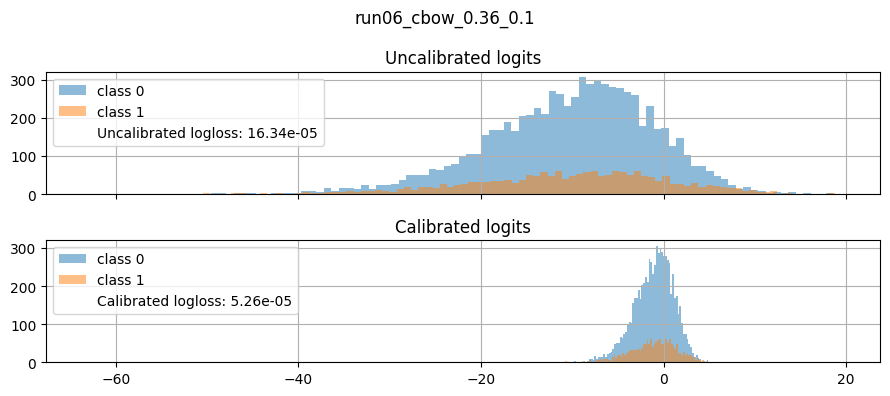

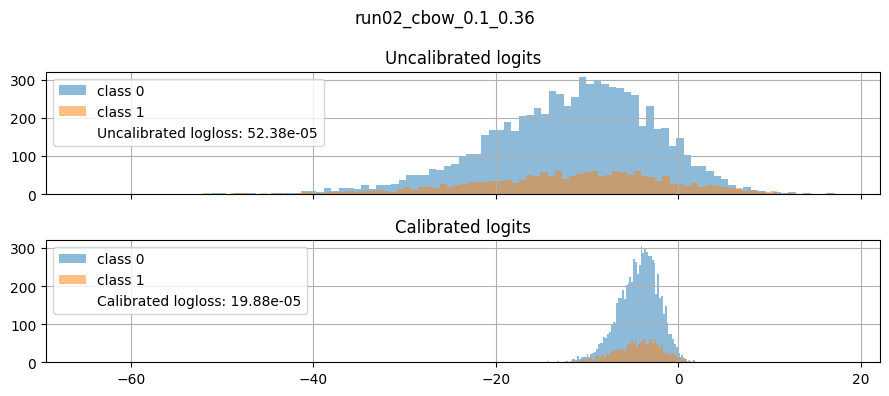

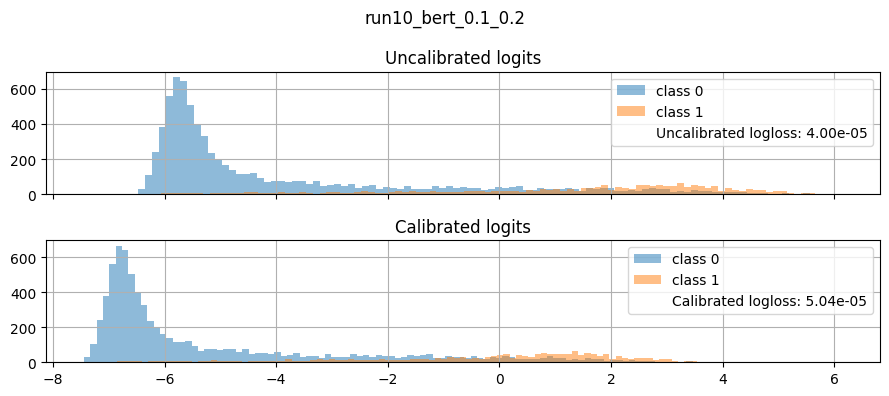

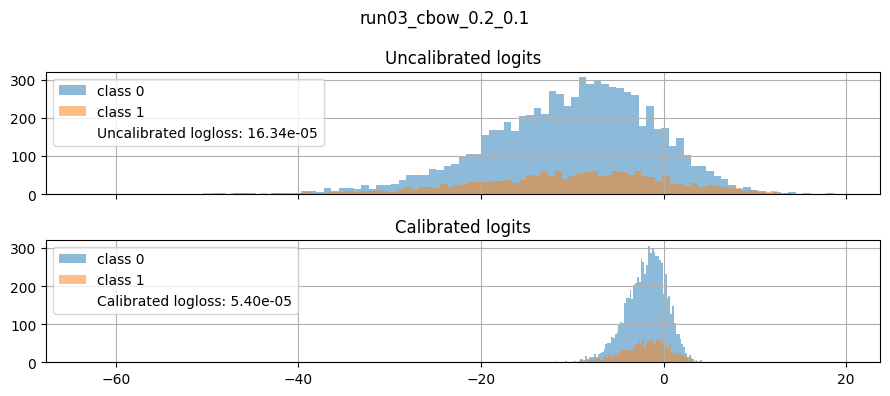

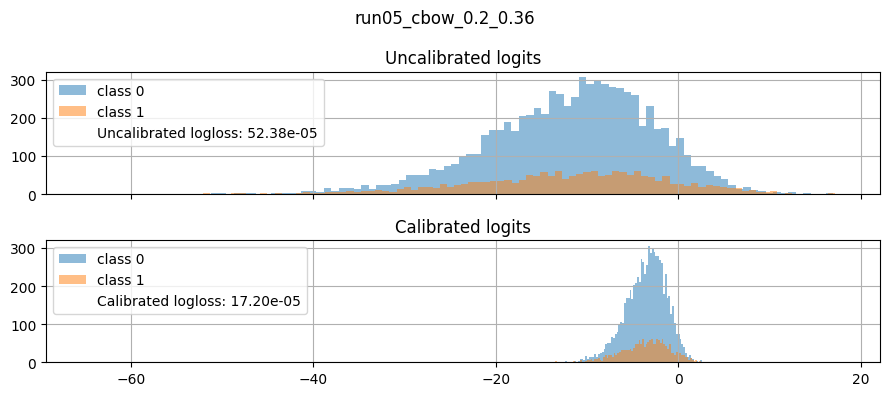

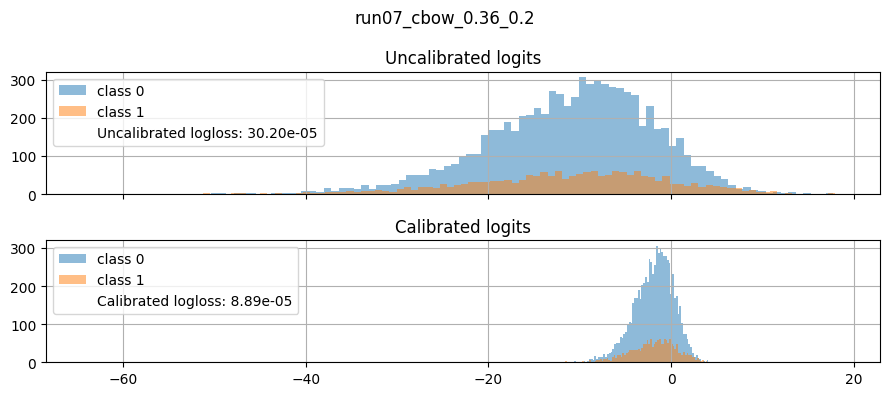

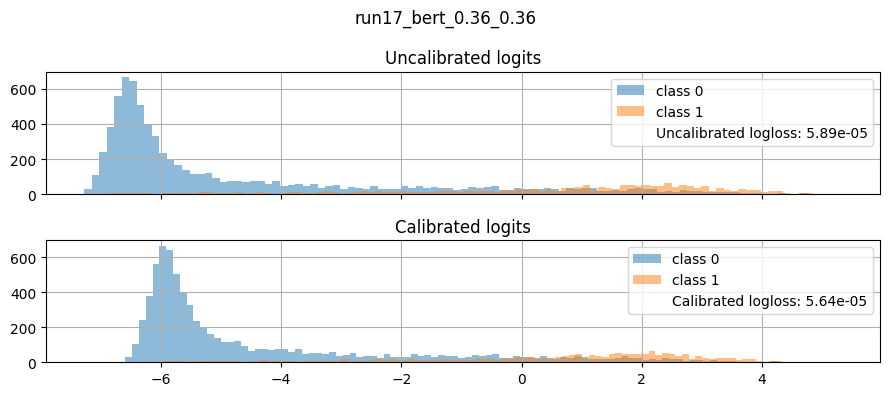

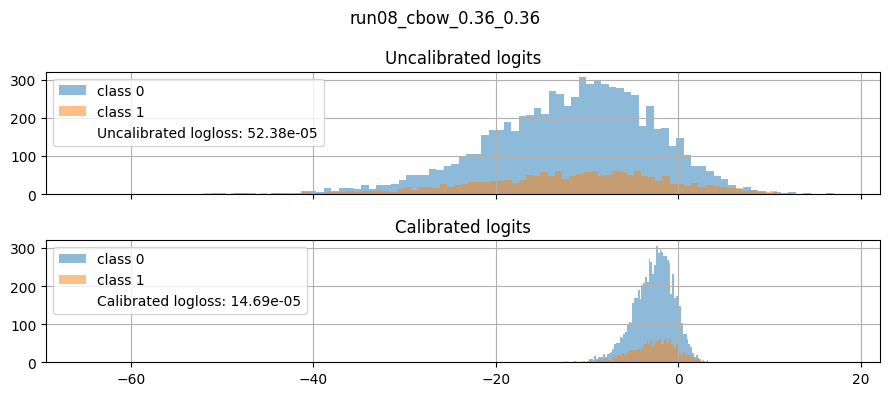

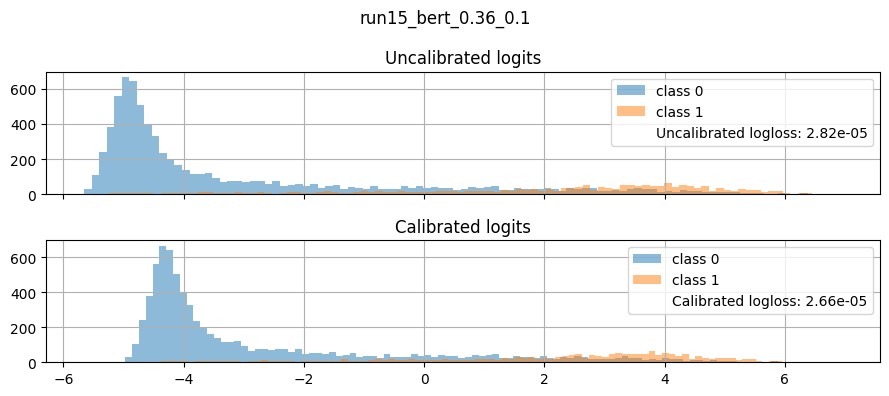

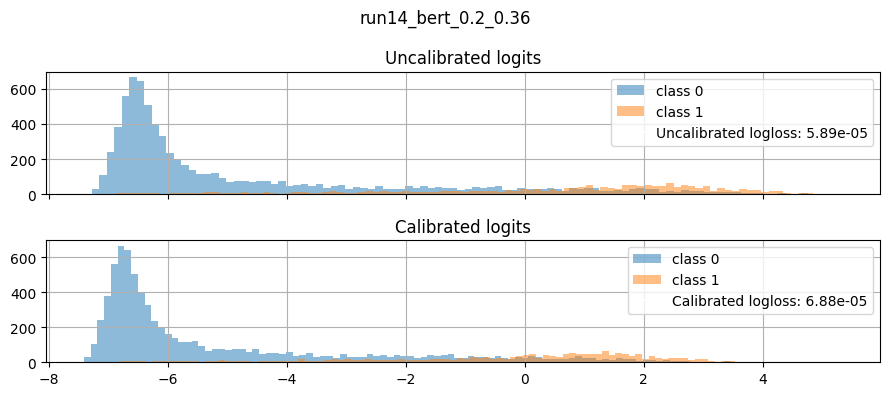

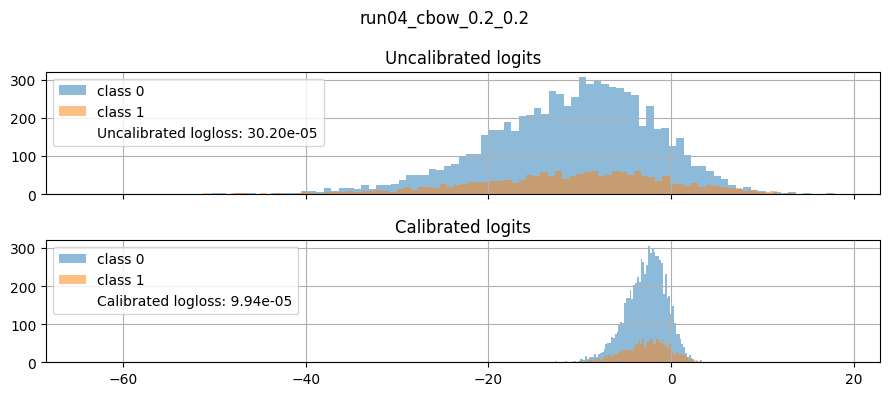

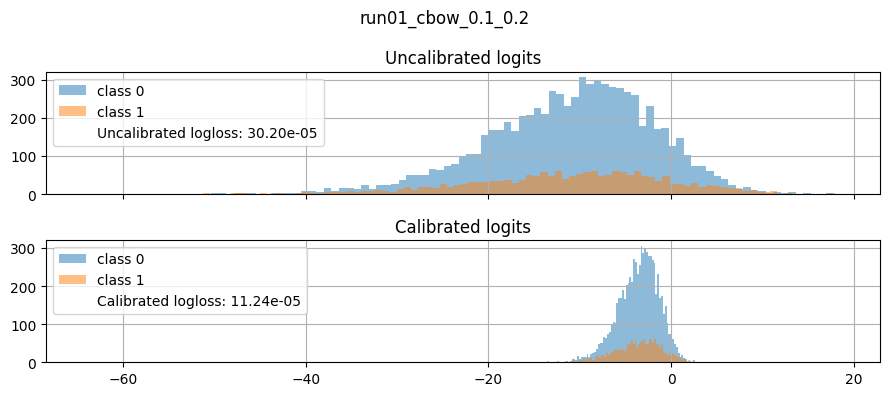

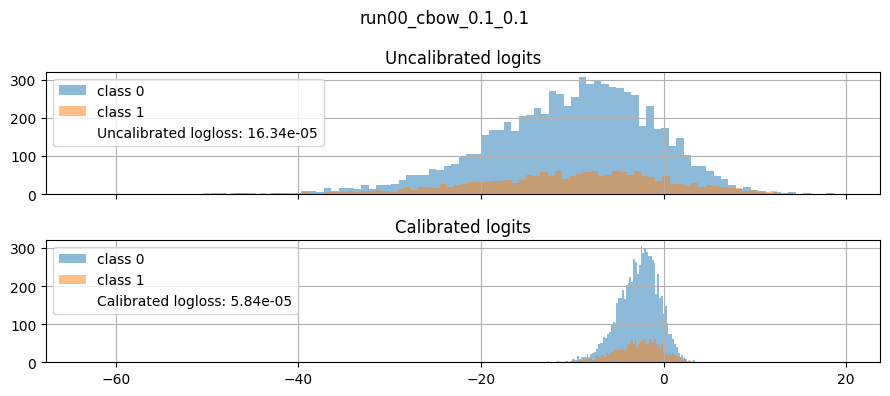

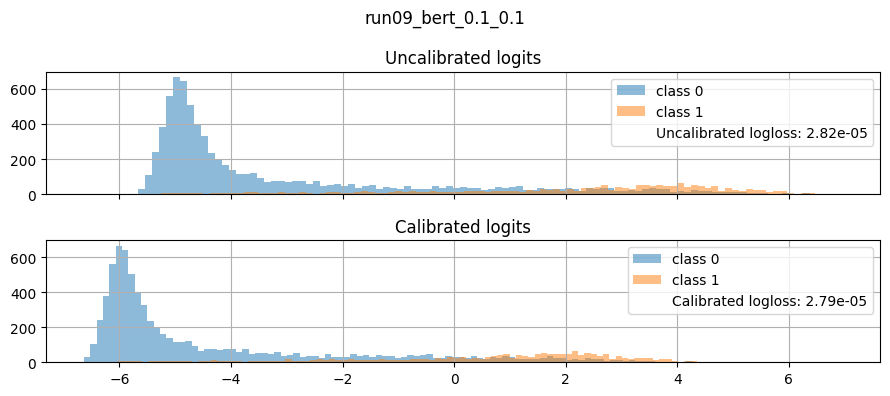

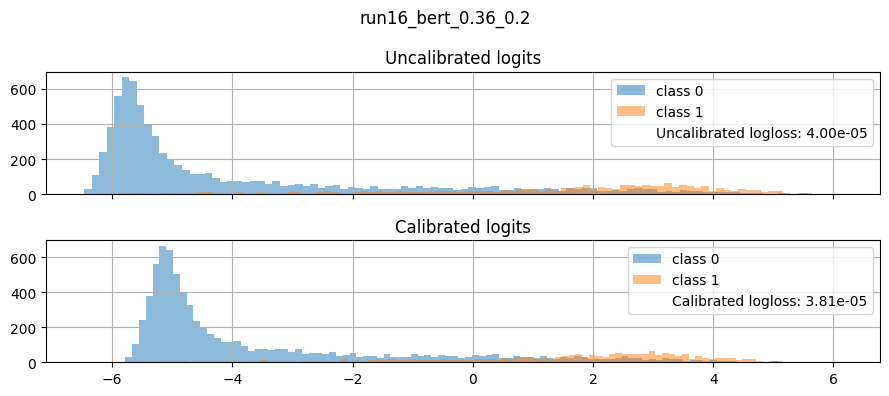

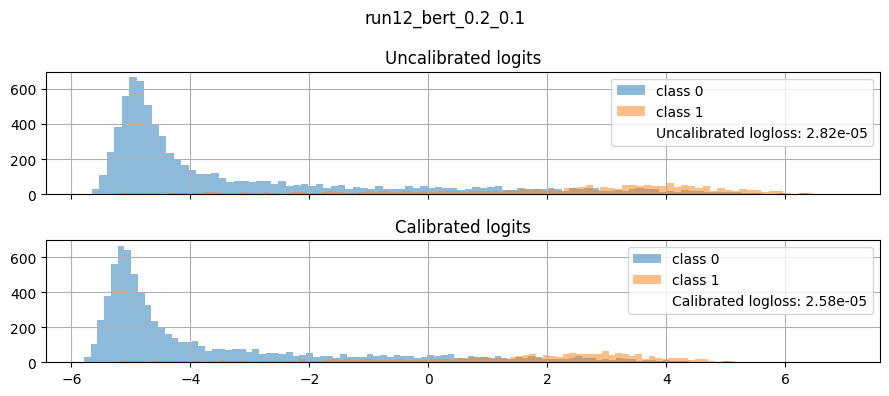

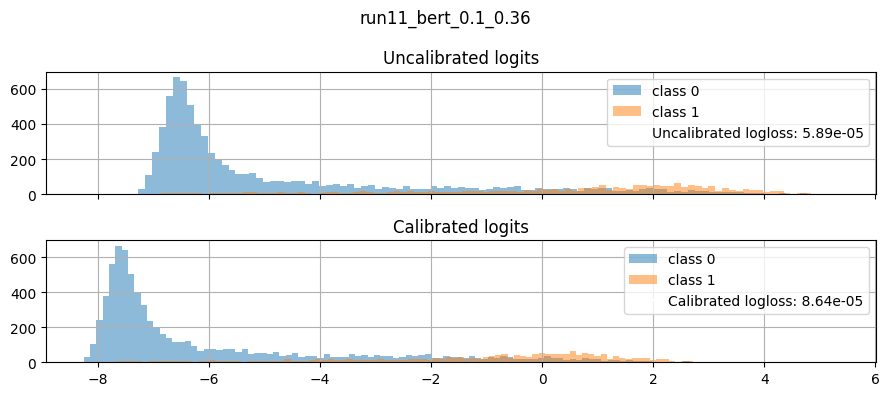

In [31]:
# def read_outputs(config_file):
#     direc = os.listdir(f"../results/{config_file}")
#     direc.remove("cache")
#     runs = {}
#     for d in direc:
#         with open(f"../results/{config_file}/{d}/00_Loading Predictions/output.pkl", "rb") as f:
#             uncalibrated_results = pickle.load(f)["calibration_validation"]
#             uncalibrated_logits = uncalibrated_results["logits"]
#             labels = uncalibrated_results["labels"]
#         with open(f"../results/{config_file}/{d}/01_Calibration/results.pkl", "rb") as f:
#             results = pickle.load(f)
#             calibrated_logits = results["logits"]
#             prior_class1 = results["prior_class1"]
#         runs[d] = {
#             "uncalibrated_logits": uncalibrated_logits,
#             "calibrated_logits": calibrated_logits,
#             "labels": labels,
#             "prior_class1": prior_class1
#         }
#     return runs

def read_outputs(config_file):
    direc = os.listdir(f"../results/{config_file}")
    direc.remove("cache")
    runs = {}
    for d in direc:
        with open(f"../results/{config_file}/{d}/01_Calibration/results.pkl", "rb") as f:
            results = pickle.load(f)
        runs[d] = {
            "validation": {
                "uncalibrated_logits": results["logits"]["uncalibrated_validation"],
                "calibrated_logits": results["logits"]["calibrated_validation"],
                "labels": results["labels"]["validation"],
                "cal_logloss": results["logloss"]["calibrated_validation"],
                "uncal_logloss": results["logloss"]["uncalibrated_validation"]
            },
            "qqp_test": {
                "uncalibrated_logits": results["logits"]["qqp_uncalibrated_test"],
                "calibrated_logits": results["logits"]["qqp_calibrated_test"],
                "labels": results["labels"]["qqp_test"],
                "cal_logloss": results["logloss"]["qqp_calibrated_test"],
                "uncal_logloss": results["logloss"]["qqp_uncalibrated_test"],
            },
            "twitter_test": {
                "uncalibrated_logits": results["logits"]["twitter_uncalibrated_test"],
                "calibrated_logits": results["logits"]["twitter_calibrated_test"],
                "labels": results["labels"]["twitter_test"],
                "cal_logloss": results["logloss"]["twitter_calibrated_test"],
                "uncal_logloss": results["logloss"]["twitter_uncalibrated_test"]
            },
            "training_prior": results["training_prior"],
            "evaluation_prior": results["evaluation_prior"],
            "parameters": results["parameters"]
        }
    return runs


def plot_logits_histograms(config_file,split="validation"):
    nbins = 100
    runs = read_outputs(config_file)

    for run_name, outputs in runs.items():
        fig, ax = plt.subplots(2,1,figsize=(9,4),sharex=True)
        l = outputs[split]["labels"]
    
        # Uncalibrated logits
        prior = outputs["evaluation_prior"]
        p = outputs[split]["uncalibrated_logits"] - np.log(prior / (1-prior))
        p_class0 = p[l == 0]
        p_class1 = p[l == 1]

        ax[0].hist(p_class0,bins=nbins,alpha=0.5,label="class 0")
        ax[0].hist(p_class1,bins=nbins,alpha=0.5,label="class 1")
        ax[0].plot([],c='w',label=f"Uncalibrated logloss: {outputs[split]['uncal_logloss']*1e5:.2f}e-05")
        ax[0].grid(True)
        ax[0].legend()
        ax[0].set_title("Uncalibrated logits")

        # Calibrated logits
        p = outputs[split]["calibrated_logits"] - np.log(prior / (1-prior))
        p_class0 = p[l == 0]
        p_class1 = p[l == 1]

        ax[1].hist(p_class0,bins=nbins,alpha=0.5,label="class 0")
        ax[1].hist(p_class1,bins=nbins,alpha=0.5,label="class 1")
        ax[1].plot([],c='w',label=f"Calibrated logloss: {outputs[split]['cal_logloss']*1e5:.2f}e-05")
        ax[1].grid(True)
        ax[1].legend()
        ax[1].set_title("Calibrated logits")
        
        fig.suptitle(run_name)
        fig.tight_layout()


plot_logits_histograms("affine",split="twitter_test")

In [3]:
runs = read_outputs("affine")
log_loss = torch.nn.BCEWithLogitsLoss()
for run_name, outputs in runs.items():
    labels = torch.from_numpy(outputs["labels"]).type(torch.float)
    cal_logits = torch.from_numpy(outputs["calibrated_logits"])
    uncal_logits = torch.from_numpy(outputs["uncalibrated_logits"])
    cal_log_loss = log_loss(cal_logits,labels).item()
    uncal_log_loss = log_loss(uncal_logits,labels).item()
    print(f"Model: {run_name.split('_')[1]}. Prior: {run_name.split('_')[3]}.",end=" ")
    print(f"Calibrated log loss: {cal_log_loss:.02f}.",end=" ")
    print(f"Uncalibrated log loss: {uncal_log_loss:.02f}.")

Model: bert. Prior: 0.6. Calibrated log loss: 0.28. Uncalibrated log loss: 0.26.
Model: cbow. Prior: 0.3. Calibrated log loss: 0.49. Uncalibrated log loss: 0.48.
Model: bert. Prior: 0.3. Calibrated log loss: 0.26. Uncalibrated log loss: 0.26.
Model: cbow. Prior: 0.6. Calibrated log loss: 0.55. Uncalibrated log loss: 0.48.
Model: bert. Prior: 0.8. Calibrated log loss: 0.38. Uncalibrated log loss: 0.26.
Model: cbow. Prior: 0.5. Calibrated log loss: 0.50. Uncalibrated log loss: 0.48.
Model: cbow. Prior: 0.4. Calibrated log loss: 0.48. Uncalibrated log loss: 0.48.
Model: bert. Prior: 0.9. Calibrated log loss: 0.51. Uncalibrated log loss: 0.26.
Model: bert. Prior: 0.4. Calibrated log loss: 0.25. Uncalibrated log loss: 0.26.
Model: bert. Prior: 0.7. Calibrated log loss: 0.32. Uncalibrated log loss: 0.26.
Model: cbow. Prior: 0.7. Calibrated log loss: 0.63. Uncalibrated log loss: 0.48.
Model: cbow. Prior: 0.1. Calibrated log loss: 0.67. Uncalibrated log loss: 0.48.
Model: bert. Prior: 0.1. Cal

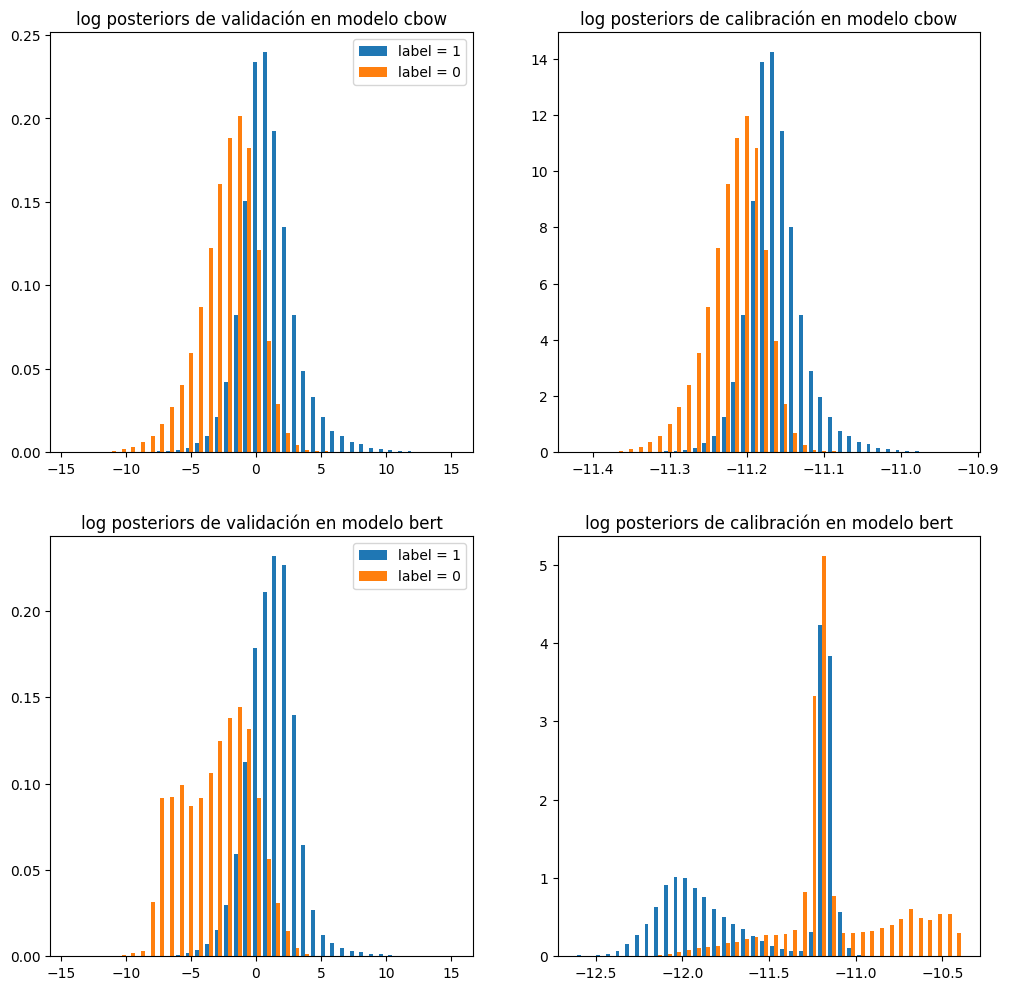

In [ ]:

outputs_validation = np.empty(shape=0)
outputs_calibration= np.empty(shape=0)
labels= np.empty(shape=0,dtype=np.int32)
fig, ax = plt.subplots(2, 2, figsize = (12,12))
ax_start=0
for model in ["cbow","bert"]:
   
   with open(path.abspath("../../00_train_system/"+model+"_results.pkl"), 'rb') as f:
      modelOutputs = pkl.load(f)
   calibrationOutputs = np.load(path.abspath(f"../../01_calibrate_system/results/{model}/run00_0/00_Calibration/results.npz"))

   outputs_validation = np.append(outputs_validation,modelOutputs["validation"]["logits"])
   outputs_calibration = np.append(outputs_calibration,calibrationOutputs["logits"])
   labels = np.append(labels,modelOutputs["validation"]["labels"])    

   


   class_1_labels = np.where(labels == 0)[0]
   class_2_labels = np.where(labels == 1)[0]
   ax[ax_start][0].set_title(f"log posteriors de validación en modelo "+model)

   ax[ax_start][0].hist([outputs_validation[class_2_labels], outputs_validation[class_1_labels]], 40, label=['label = 1', 'label = 0'],density=True)
   ax[ax_start][0].legend(loc='upper right')

   ax[ax_start][1].set_title(f"log posteriors de calibración en modelo "+model)

   ax[ax_start][1].hist([outputs_calibration[class_2_labels], outputs_calibration[class_1_labels]], 40, label=['label = 1', 'label = 0'],density=True);

   ax_start +=1

